In [1]:
from database.comet import Comet
from database.market import Market
from modeler.modeler import Modeler as m
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
import matplotlib
from datetime import datetime, timedelta
from statistics import mean
from tqdm import tqdm

In [2]:
comet = Comet()
market = Market()

In [3]:
comet.connect()
prices = comet.retrieve("alpha_prices")
comet.disconnect()

In [5]:
market.connect()
stocks = []
for ticker in ["FB","TSLA"]:
    ticker_data = market.retrieve_ticker_prices("prices",ticker)
    stocks.append(ticker_data)
market.disconnect()
stocks = pd.concat(stocks)

In [37]:
stocks = p.column_date_processing(stocks)
market = stocks.pivot_table(index="date",columns="ticker",values="adjclose")
market = p.column_date_processing(market)

In [38]:
oil = pd.read_csv("./data/DCOILWTICO.csv")
oil = p.column_date_processing(oil)

In [39]:
oil

,date,dcoilwtico
0,2014-01-02,95.14
1,2014-01-03,93.66
2,2014-01-06,93.12
3,2014-01-07,93.31
4,2014-01-08,91.90
...,...,...
2082,2021-12-27,75.49
2083,2021-12-28,76.01
2084,2021-12-29,76.58
2085,2021-12-30,76.83


In [49]:
crypto_market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
crypto_market = p.column_date_processing(crypto_market)
crypto_market = crypto_market.fillna(method="ffill").dropna()
symbols = [x.lower() for x in ['ADA', 'BTC', 'DOGE', 'ETH', 'SHIB', 'LUNA','AVAX', 'LTC', 'DOT']]
crypto_market = crypto_market[symbols+["date"]]

In [50]:
oil["dcoilwtico"] = pd.to_numeric(oil['dcoilwtico'],errors='coerce')

In [51]:
merged = crypto_market.merge(oil,on="date").merge(market,on="date")

In [52]:
merged.corr()

,ada,btc,doge,eth,shib,luna,avax,ltc,dot,dcoilwtico,fb,tsla
ada,1.000000,0.493812,0.291454,0.405424,0.035871,0.199519,0.192346,0.370591,0.544690,0.133483,0.313323,0.083752
btc,0.493812,1.000000,0.014202,0.929987,0.801212,0.682956,0.717853,0.597404,0.910247,0.563024,-0.246613,0.766569
doge,0.291454,0.014202,1.000000,0.006094,-0.111471,-0.400747,-0.332758,0.680299,0.232171,-0.341711,-0.284725,-0.413324
eth,0.405424,0.929987,0.006094,1.000000,0.812062,0.809678,0.834440,0.607174,0.872878,0.375351,-0.282610,0.816922
shib,0.035871,0.801212,-0.111471,0.812062,1.000000,0.666058,0.719844,0.431733,0.749751,0.590304,-0.490837,0.884209
luna,0.199519,0.682956,-0.400747,0.809678,0.666058,1.000000,0.913086,0.152697,0.559485,0.336042,-0.172784,0.814068
avax,0.192346,0.717853,-0.332758,0.834440,0.719844,0.913086,1.000000,0.287842,0.646076,0.358548,-0.254634,0.859783
ltc,0.370591,0.597404,0.680299,0.607174,0.431733,0.152697,0.287842,1.000000,0.709686,0.013351,-0.418948,0.191941
dot,0.544690,0.910247,0.232171,0.872878,0.749751,0.559485,0.646076,0.709686,1.000000,0.513560,-0.342751,0.670324
dcoilwtico,0.133483,0.563024,-0.341711,0.375351,0.590304,0.336042,0.358548,0.013351,0.513560,1.000000,-0.137803,0.579426


In [53]:
merged.head()

,ada,btc,doge,eth,shib,luna,avax,ltc,dot,date,dcoilwtico,fb,tsla
0,1.6423,55816.14,0.45074,3945.88,0.000035,15.850,34.652,358.89,36.488,2021-05-10,64.92,305.97,629.04
1,1.7632,56670.02,0.49326,4173.45,0.000030,16.310,36.800,377.60,38.637,2021-05-11,65.31,306.53,617.20
2,1.5694,49631.32,0.39160,3823.21,0.000018,14.619,32.800,310.40,35.128,2021-05-12,65.96,302.55,589.89
3,1.9296,49670.97,0.48945,3717.91,0.000021,15.911,35.075,317.95,39.988,2021-05-13,63.82,305.26,571.69
4,2.0069,49841.45,0.55971,4075.01,0.000018,16.403,36.999,326.23,47.979,2021-05-14,65.32,315.94,589.74


In [107]:
training_start = datetime(2021,5,10)
training_end = datetime(2021,10,1)
retrack_days = [2,4,8]
projection_days = [1,3,7]
sims = []
for retrack_day in retrack_days:
    for projection_day in projection_days:
        for symbol in tqdm(symbols):
            try:
                symbol_data = merged.copy()
                for i in range(1,retrack_day):
                    symbol_data[str(i)] = symbol_data[symbol].shift(i)
                symbol_data["p1"] = symbol_data[symbol].pct_change(retrack_day-1)
                symbol_data["p2"] = symbol_data["p1"].pct_change()
                symbol_data["p3"] = symbol_data["p2"].pct_change()
                symbol_data.dropna(inplace=True)
                symbol_data["y"] = symbol_data[symbol].shift(-projection_day)
                training_data = symbol_data[(symbol_data["date"]>=training_start) & (symbol_data["date"]<training_end)].dropna()
                training_data.reset_index(inplace=True,drop=True)
                prediction_data = symbol_data[(symbol_data["date"]>training_end)].dropna()
                factors = [x for x in symbol_data.columns if x not in ["date","y"]]
                refined = {"X":training_data[factors],"y":training_data[["y"]]}
                models = m.regression(refined)
                for row in models.iterrows():
                    sim = prediction_data 
                    current_model = row[1]["model"]
                    api = row[1]["api"]
                    score = row[1]["score"]
                    if score > 0.7:
                        predictions = current_model.predict(prediction_data[factors])
                        sim[f'{api}_prediction'] = predictions
                sim["prediction"] = [mean(row[1][column] for column in [x for x in sim.columns if "prediction" in x]) for row in sim.iterrows()]
                sim["symbol"] = symbol
                sim["retrack_day"] = retrack_day
                sim["projection_day"] = projection_day
                sims.append(sim)
            except Exception as e:
                print(str(e))

 44%|████████████████████████████████████████████████████████                                                                      | 4/9 [00:18<00:23,  4.68s/it]

[19:27:36] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`


 56%|██████████████████████████████████████████████████████████████████████                                                        | 5/9 [00:22<00:17,  4.37s/it]

mean requires at least one data point


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.54s/it]


mean requires at least one data point


 33%|██████████████████████████████████████████                                                                                    | 3/9 [00:13<00:27,  4.53s/it]

mean requires at least one data point


 44%|████████████████████████████████████████████████████████                                                                      | 4/9 [00:18<00:22,  4.57s/it]

[19:28:16] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`


 56%|██████████████████████████████████████████████████████████████████████                                                        | 5/9 [00:22<00:17,  4.37s/it]

mean requires at least one data point


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8/9 [00:36<00:04,  4.55s/it]

mean requires at least one data point


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.56s/it]


mean requires at least one data point


 44%|████████████████████████████████████████████████████████                                                                      | 4/9 [00:19<00:24,  4.95s/it]

[19:28:59] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:981: Check failed: valid: Input data contains `inf` or `nan`


 56%|██████████████████████████████████████████████████████████████████████                                                        | 5/9 [00:24<00:19,  4.93s/it]

mean requires at least one data point


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.91s/it]


mean requires at least one data point


 56%|██████████████████████████████████████████████████████████████████████                                                        | 5/9 [00:24<00:19,  4.75s/it]

mean requires at least one data point


 33%|██████████████████████████████████████████                                                                                    | 3/9 [00:14<00:28,  4.82s/it]

mean requires at least one data point


 56%|██████████████████████████████████████████████████████████████████████                                                        | 5/9 [00:24<00:20,  5.01s/it]

mean requires at least one data point


 56%|██████████████████████████████████████████████████████████████████████                                                        | 5/9 [00:24<00:20,  5.00s/it]

mean requires at least one data point


 33%|██████████████████████████████████████████                                                                                    | 3/9 [00:14<00:28,  4.83s/it]

mean requires at least one data point


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.92s/it]


In [108]:
pd.concat(sims)

,ada,btc,doge,eth,shib,luna,avax,ltc,dot,date,...,prediction,symbol,retrack_day,projection_day,2,3,4,5,6,7
102,2.191,49224.94,0.2414,3386.31,0.000013,46.80,65.29,167.5,31.15,2021-10-04,...,2.106575,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
103,2.233,51471.99,0.2516,3515.27,0.000017,44.66,64.60,173.8,31.39,2021-10-05,...,2.177180,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
104,2.209,55315.00,0.2541,3574.89,0.000028,42.02,60.01,178.5,32.19,2021-10-06,...,2.199081,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
105,2.278,53785.22,0.2428,3587.47,0.000023,46.58,61.52,178.6,33.98,2021-10-07,...,2.224200,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
106,2.237,53951.43,0.2441,3563.13,0.000027,43.30,60.51,175.9,33.35,2021-10-08,...,2.153734,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1.211,47140.54,0.1641,3897.94,0.000033,60.86,80.61,148.3,26.44,2021-12-10,...,27.304184,dot,8,7,29.84,30.50,28.13,33.70,35.75,36.76
151,1.223,46702.75,0.1573,3781.93,0.000033,52.96,79.05,144.6,25.96,2021-12-13,...,27.593779,dot,8,7,26.90,29.84,30.50,28.13,33.70,35.75
152,1.266,48343.28,0.1909,3858.99,0.000034,60.19,87.17,150.4,26.15,2021-12-14,...,27.394761,dot,8,7,26.44,26.90,29.84,30.50,28.13,33.70
153,1.311,48864.98,0.1808,4019.08,0.000034,61.66,101.24,153.6,27.14,2021-12-15,...,26.994990,dot,8,7,25.96,26.44,26.90,29.84,30.50,28.13


In [109]:
final = pd.concat(sims)

In [110]:
final["symbol"].unique()

array(['ada', 'btc', 'doge', 'eth', 'luna', 'avax', 'ltc', 'shib', 'dot'],
      dtype=object)

In [111]:
final

,ada,btc,doge,eth,shib,luna,avax,ltc,dot,date,...,prediction,symbol,retrack_day,projection_day,2,3,4,5,6,7
102,2.191,49224.94,0.2414,3386.31,0.000013,46.80,65.29,167.5,31.15,2021-10-04,...,2.106575,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
103,2.233,51471.99,0.2516,3515.27,0.000017,44.66,64.60,173.8,31.39,2021-10-05,...,2.177180,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
104,2.209,55315.00,0.2541,3574.89,0.000028,42.02,60.01,178.5,32.19,2021-10-06,...,2.199081,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
105,2.278,53785.22,0.2428,3587.47,0.000023,46.58,61.52,178.6,33.98,2021-10-07,...,2.224200,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
106,2.237,53951.43,0.2441,3563.13,0.000027,43.30,60.51,175.9,33.35,2021-10-08,...,2.153734,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1.211,47140.54,0.1641,3897.94,0.000033,60.86,80.61,148.3,26.44,2021-12-10,...,27.304184,dot,8,7,29.84,30.50,28.13,33.70,35.75,36.76
151,1.223,46702.75,0.1573,3781.93,0.000033,52.96,79.05,144.6,25.96,2021-12-13,...,27.593779,dot,8,7,26.90,29.84,30.50,28.13,33.70,35.75
152,1.266,48343.28,0.1909,3858.99,0.000034,60.19,87.17,150.4,26.15,2021-12-14,...,27.394761,dot,8,7,26.44,26.90,29.84,30.50,28.13,33.70
153,1.311,48864.98,0.1808,4019.08,0.000034,61.66,101.24,153.6,27.14,2021-12-15,...,26.994990,dot,8,7,25.96,26.44,26.90,29.84,30.50,28.13


In [112]:
prices = p.column_date_processing(prices)

In [113]:
final.rename(columns={"y":"close"},inplace=True,errors="ignore")

In [114]:
final["signal"] = (final["prediction"] - final["close"]) / final["close"]

In [115]:
final

,ada,btc,doge,eth,shib,luna,avax,ltc,dot,date,...,symbol,retrack_day,projection_day,2,3,4,5,6,7,signal
102,2.191,49224.94,0.2414,3386.31,0.000013,46.80,65.29,167.5,31.15,2021-10-04,...,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN,-0.056617
103,2.233,51471.99,0.2516,3515.27,0.000017,44.66,64.60,173.8,31.39,2021-10-05,...,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN,-0.014405
104,2.209,55315.00,0.2541,3574.89,0.000028,42.02,60.01,178.5,32.19,2021-10-06,...,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN,-0.034644
105,2.278,53785.22,0.2428,3587.47,0.000023,46.58,61.52,178.6,33.98,2021-10-07,...,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN,-0.005722
106,2.237,53951.43,0.2441,3563.13,0.000027,43.30,60.51,175.9,33.35,2021-10-08,...,ada,2,1,NaN,NaN,NaN,NaN,NaN,NaN,-0.007953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1.211,47140.54,0.1641,3897.94,0.000033,60.86,80.61,148.3,26.44,2021-12-10,...,dot,8,7,29.84,30.50,28.13,33.70,35.75,36.76,0.085222
151,1.223,46702.75,0.1573,3781.93,0.000033,52.96,79.05,144.6,25.96,2021-12-13,...,dot,8,7,26.90,29.84,30.50,28.13,33.70,35.75,0.013732
152,1.266,48343.28,0.1909,3858.99,0.000034,60.19,87.17,150.4,26.15,2021-12-14,...,dot,8,7,26.44,26.90,29.84,30.50,28.13,33.70,-0.060536
153,1.311,48864.98,0.1808,4019.08,0.000034,61.66,101.24,153.6,27.14,2021-12-15,...,dot,8,7,25.96,26.44,26.90,29.84,30.50,28.13,-0.128350


In [116]:
market = final.copy()

In [119]:
market.columns

Index(['ada', 'btc', 'doge', 'eth', 'shib', 'luna', 'avax', 'ltc', 'dot',
       'date', 'dcoilwtico', 'fb', 'tsla', '1', 'p1', 'p2', 'p3', 'close',
       'xgb_prediction', 'cat_prediction', 'prediction', 'symbol',
       'retrack_day', 'projection_day', '2', '3', '4', '5', '6', '7',
       'signal'],
      dtype='object')

In [183]:
signals = range(0,60,10)
reqs = range(10,60,10)
trades = []
start = datetime(2021,10,1)
end = datetime(2022,1,1)
for retrack_day in retrack_days:
    for projection_day in projection_days:
        for conservative in [True,False]:
            for value in [True,False]:
                for s in tqdm(signals):
                    for r in reqs:
                        signal = float(s/100)
                        req = float(r/100)
                        date = start
                        while date < end:
                            try:
                                futures = market[(market["date"]>date) & (market["retrack_day"]==retrack_day) & (market["projection_day"]==projection_day)]
                                futures.sort_values("date",inplace=True)
                                if value:
                                    entries = futures[(futures["signal"] <= -signal)].sort_values(by="signal",ascending=conservative)
                                else:
                                    sorting = not conservative
                                    entries = futures[(futures["signal"] >= signal)].sort_values(by="signal",ascending=sorting)
                                if entries.index.size < 1:
                                    if (end-date).days < retrack_day:
                                        break
                                    else:
                                        date = date + timedelta(days=1)
                                else:
                                    trade = entries.iloc[0]
                                    symbol = trade["symbol"]
                                    exits = market[(market["date"]>trade["date"]) & (market["symbol"]==symbol)]
                                    bp = trade["close"]
                                    due_date = trade["date"]+timedelta(days=projection_day)
                                    exits["delta"] = (exits["close"] - bp) / bp
                                    profits = exits[(exits["delta"] >= req) & (exits["date"] <= due_date)]
                                    breakeven = exits[(exits["delta"]>=0) & (exits["date"] > due_date)]
                                    if profits.index.size < 1:
                                        if breakeven.index.size < 1:
                                            exit = exits[(exits["date"] > due_date)].iloc[-1]
                                            trade["sell_price"] = exit["close"]
                                            trade["type"] = "loss"
                                        else:
                                            exit = breakeven.iloc[0]
                                            trade["type"] = "breakeven"
                                            trade["sell_price"] = bp
                                    else:
                                        exit = profits.iloc[0]
                                        trade["type"] = "profit"
                                        trade["sell_price"] = bp * (1+req)
                                    trade["sell_date"] = exit["date"]
                                    trade["buy_price"] = bp
                                    trade["delta"] = (trade["sell_price"] - trade["buy_price"])/ trade["buy_price"]
                                    trade["signal"] = signal
                                    trade["req"] = req
                                    trade["symbol"] = symbol
                                    trade["conservative"] = conservative
                                    trade["value"] = value
                                    trade["projection_day"] = projection_day
                                    trade["retrack_day"] = retrack_day
                                    trades.append(trade)
                                    date = exit["date"] + timedelta(days=1)
                            except Exception as e:
                                print(date,str(e))
                                date = date + timedelta(days=1)

 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  5.38it/s]

2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  5.32it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of

 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  5.36it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4/6 [00:00<00:00,  5.31it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5/6 [00:00<00:00,  5.31it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of

 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  6.53it/s]

2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of

 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  6.29it/s]

2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds


 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  7.37it/s]

2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4/6 [00:00<00:00,  5.43it/s]

2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.98it/s]


2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

  0%|                                                                                                                                      | 0/6 [00:00<?, ?it/s]

2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds


 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  5.55it/s]

2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  6.67it/s]

2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of

 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  4.59it/s]

2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-10-01 00:00:00 single positional indexer is out-of-bounds
2021-10-02 00:00:00 single positional indexer is out-of-bounds
2021-10-03 00:00:00 single positional indexer is out-of-bounds
2021-10-04 00:00:00 single positional indexer is out-of-bounds
2021-10-05 00:00:00 single positional indexer is out-of-bounds
2021-10-06 00:00:00 single positional indexer is out-of-bounds
2021-10-07 00:00:00 single positional indexer is out-of-bounds
2021-10-08 00:00:00 single positional indexer is out-of-bounds
2021-10-09 00:00:00 single positional indexer is out-of-bounds
2021-10-10 00:00:00 single positional indexer is out-of-bounds
2021-10-11 00:00:00 single positional indexer is out-of-bounds
2021-10-12 00:00:00 single positional indexer is out-of

2021-11-10 00:00:00 single positional indexer is out-of-bounds
2021-11-11 00:00:00 single positional indexer is out-of-bounds
2021-11-12 00:00:00 single positional indexer is out-of-bounds
2021-11-13 00:00:00 single positional indexer is out-of-bounds
2021-11-14 00:00:00 single positional indexer is out-of-bounds
2021-11-15 00:00:00 single positional indexer is out-of-bounds
2021-11-16 00:00:00 single positional indexer is out-of-bounds
2021-11-17 00:00:00 single positional indexer is out-of-bounds
2021-11-18 00:00:00 single positional indexer is out-of-bounds
2021-11-19 00:00:00 single positional indexer is out-of-bounds
2021-11-20 00:00:00 single positional indexer is out-of-bounds
2021-11-21 00:00:00 single positional indexer is out-of-bounds
2021-11-22 00:00:00 single positional indexer is out-of-bounds
2021-11-23 00:00:00 single positional indexer is out-of-bounds
2021-11-24 00:00:00 single positional indexer is out-of-bounds
2021-11-25 00:00:00 single positional indexer is out-of

2021-10-21 00:00:00 single positional indexer is out-of-bounds
2021-10-22 00:00:00 single positional indexer is out-of-bounds
2021-10-23 00:00:00 single positional indexer is out-of-bounds
2021-10-24 00:00:00 single positional indexer is out-of-bounds
2021-10-25 00:00:00 single positional indexer is out-of-bounds
2021-10-26 00:00:00 single positional indexer is out-of-bounds
2021-10-27 00:00:00 single positional indexer is out-of-bounds
2021-10-28 00:00:00 single positional indexer is out-of-bounds
2021-10-29 00:00:00 single positional indexer is out-of-bounds
2021-10-30 00:00:00 single positional indexer is out-of-bounds
2021-10-31 00:00:00 single positional indexer is out-of-bounds
2021-11-01 00:00:00 single positional indexer is out-of-bounds
2021-11-02 00:00:00 single positional indexer is out-of-bounds
2021-11-03 00:00:00 single positional indexer is out-of-bounds
2021-11-04 00:00:00 single positional indexer is out-of-bounds
2021-11-05 00:00:00 single positional indexer is out-of

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5/6 [00:02<00:00,  1.79it/s]

2021-11-14 00:00:00 single positional indexer is out-of-bounds
2021-11-15 00:00:00 single positional indexer is out-of-bounds
2021-11-16 00:00:00 single positional indexer is out-of-bounds
2021-11-17 00:00:00 single positional indexer is out-of-bounds
2021-11-18 00:00:00 single positional indexer is out-of-bounds
2021-11-19 00:00:00 single positional indexer is out-of-bounds
2021-11-20 00:00:00 single positional indexer is out-of-bounds
2021-11-21 00:00:00 single positional indexer is out-of-bounds
2021-11-22 00:00:00 single positional indexer is out-of-bounds
2021-11-23 00:00:00 single positional indexer is out-of-bounds
2021-11-24 00:00:00 single positional indexer is out-of-bounds
2021-11-25 00:00:00 single positional indexer is out-of-bounds
2021-11-26 00:00:00 single positional indexer is out-of-bounds
2021-11-27 00:00:00 single positional indexer is out-of-bounds
2021-11-28 00:00:00 single positional indexer is out-of-bounds
2021-11-29 00:00:00 single positional indexer is out-of

 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  7.46it/s]

2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4/6 [00:00<00:00,  5.25it/s]

2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5/6 [00:00<00:00,  4.47it/s]

2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.35it/s]


2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds


 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  5.78it/s]

2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  5.66it/s]

2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of

 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  5.69it/s]

single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 0

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 4/6 [00:00<00:00,  5.67it/s]

single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 0

 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  5.71it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of

 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  6.90it/s]

2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5/6 [00:00<00:00,  8.29it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds


 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00, 10.88it/s]

2021-10-01 00:00:00 single positional indexer is out-of-bounds
2021-10-02 00:00:00 single positional indexer is out-of-bounds
2021-10-03 00:00:00 single positional indexer is out-of-bounds
2021-10-04 00:00:00 single positional indexer is out-of-bounds
2021-10-05 00:00:00 single positional indexer is out-of-bounds
2021-10-06 00:00:00 single positional indexer is out-of-bounds
2021-10-07 00:00:00 single positional indexer is out-of-bounds
2021-10-08 00:00:00 single positional indexer is out-of-bounds
2021-10-09 00:00:00 single positional indexer is out-of-bounds
2021-10-10 00:00:00 single positional indexer is out-of-bounds
2021-10-11 00:00:00 single positional indexer is out-of-bounds
2021-10-12 00:00:00 single positional indexer is out-of-bounds
2021-10-13 00:00:00 single positional indexer is out-of-bounds
2021-10-14 00:00:00 single positional indexer is out-of-bounds
2021-10-15 00:00:00 single positional indexer is out-of-bounds
2021-10-16 00:00:00 single positional indexer is out-of

2021-12-05 00:00:00 single positional indexer is out-of-bounds
2021-12-06 00:00:00 single positional indexer is out-of-bounds
2021-12-07 00:00:00 single positional indexer is out-of-bounds
2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-16 00:00:00 single positional indexer is out-of-bounds
2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of

2021-11-16 00:00:00 single positional indexer is out-of-bounds
2021-11-17 00:00:00 single positional indexer is out-of-bounds
2021-11-18 00:00:00 single positional indexer is out-of-bounds
2021-11-19 00:00:00 single positional indexer is out-of-bounds
2021-11-20 00:00:00 single positional indexer is out-of-bounds
2021-11-21 00:00:00 single positional indexer is out-of-bounds
2021-11-22 00:00:00 single positional indexer is out-of-bounds
2021-11-23 00:00:00 single positional indexer is out-of-bounds
2021-11-24 00:00:00 single positional indexer is out-of-bounds
2021-11-25 00:00:00 single positional indexer is out-of-bounds
2021-11-26 00:00:00 single positional indexer is out-of-bounds
2021-11-27 00:00:00 single positional indexer is out-of-bounds
2021-11-28 00:00:00 single positional indexer is out-of-bounds
2021-11-29 00:00:00 single positional indexer is out-of-bounds
2021-11-30 00:00:00 single positional indexer is out-of-bounds
2021-12-01 00:00:00 single positional indexer is out-of

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5/6 [00:01<00:00,  2.15it/s]

2021-12-05 00:00:00 single positional indexer is out-of-bounds
2021-12-06 00:00:00 single positional indexer is out-of-bounds
2021-12-07 00:00:00 single positional indexer is out-of-bounds
2021-12-08 00:00:00 single positional indexer is out-of-bounds
2021-12-09 00:00:00 single positional indexer is out-of-bounds
2021-12-10 00:00:00 single positional indexer is out-of-bounds
2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-16 00:00:00 single positional indexer is out-of-bounds
2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of

 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  6.06it/s]

2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  6.04it/s]

2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of

 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  6.00it/s]

2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of

 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  5.88it/s]

2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-17 00:00:00 single positional indexer is out-of

 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  6.26it/s]

2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-10-30 00:00:00 single positional indexer is out-of-bounds
2021-10-31 00:00:00 single positional indexer is out-of-bounds
2021-11-01 00:00:00 single positional indexer is out-of-bounds
2021-11-02 00:00:00 single positional indexer is out-of-bounds
2021-11-03 00:00:00 single positional indexer is out-of-bounds
2021-11-04 00:00:00 single positional indexer is out-of-bounds
2021-11-05 00:00:00 single positional indexer is out-of

2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-11-02 00:00:00 single positional indexer is out-of-bounds
2021-11-03 00:00:00 single positional indexer is out-of-bounds
2021-11-04 00:00:00 single positional indexer is out-of-bounds
2021-11-05 00:00:00 single positional indexer is out-of-bounds
2021-11-06 00:00:00 single positional indexer is out-of-bounds
2021-11-07 00:00:00 single positional indexer is out-of-bounds
2021-11-08 00:00:00 single positional indexer is out-of-bounds
2021-11-09 00:00:00 single positional indexer is out-of-bounds
2021-11-10 00:00:00 single positional indexer is out-of-bounds
2021-11-11 00:00:00 single positional indexer is out-of-bounds
2021-11-12 00:00:00 single positional indexer is out-of-bounds
2021-11-13 00:00:00 single positional indexer is out-of

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.57it/s]


2021-12-11 00:00:00 single positional indexer is out-of-bounds
2021-12-12 00:00:00 single positional indexer is out-of-bounds
2021-12-13 00:00:00 single positional indexer is out-of-bounds
2021-12-14 00:00:00 single positional indexer is out-of-bounds
2021-12-15 00:00:00 single positional indexer is out-of-bounds
2021-12-16 00:00:00 single positional indexer is out-of-bounds
2021-12-17 00:00:00 single positional indexer is out-of-bounds
2021-12-18 00:00:00 single positional indexer is out-of-bounds
2021-12-19 00:00:00 single positional indexer is out-of-bounds
2021-12-20 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of

  0%|                                                                                                                                      | 0/6 [00:00<?, ?it/s]

2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds


 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:00,  9.09it/s]

2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds


 33%|██████████████████████████████████████████                                                                                    | 2/6 [00:00<00:00,  8.72it/s]

2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds


 50%|███████████████████████████████████████████████████████████████                                                               | 3/6 [00:00<00:00,  7.89it/s]

2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of-bounds
2021-12-21 00:00:00 single positional indexer is out-of-bounds
2021-12-22 00:00:00 single positional indexer is out-of-bounds
2021-12-23 00:00:00 single positional indexer is out-of-bounds
2021-12-24 00:00:00 single positional indexer is out-of-bounds
2021-12-25 00:00:00 single positional indexer is out-of-bounds
2021-12-26 00:00:00 single positional indexer is out-of

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.13it/s]


In [184]:
t = pd.DataFrame(trades)

In [185]:
t.head(10)

,ada,btc,doge,eth,shib,luna,avax,ltc,dot,date,...,7,signal,sell_price,type,sell_date,buy_price,delta,req,conservative,value
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.0,85.16,loss,2021-12-27,94.39,-0.097786,0.1,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.0,85.16,loss,2021-12-27,94.39,-0.097786,0.2,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.0,85.16,loss,2021-12-27,94.39,-0.097786,0.3,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.0,85.16,loss,2021-12-27,94.39,-0.097786,0.4,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.0,85.16,loss,2021-12-27,94.39,-0.097786,0.5,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.1,85.16,loss,2021-12-27,94.39,-0.097786,0.1,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.1,85.16,loss,2021-12-27,94.39,-0.097786,0.2,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.1,85.16,loss,2021-12-27,94.39,-0.097786,0.3,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.1,85.16,loss,2021-12-27,94.39,-0.097786,0.4,True,True
158,1.327,48588.16,0.173,3979.51,0.000035,85.38,116.69,155.4,27.22,2021-12-22,...,NaN,0.1,85.16,loss,2021-12-27,94.39,-0.097786,0.5,True,True


In [186]:
analysis = []
for retrack_day in retrack_days:
    for projection_day in projection_days:
        for value in [True,False]:
            for conservative in [True,False]:
                for s in tqdm(signals):
                    for r in reqs:
                        try:
                            signal = float(s/100)
                            req = float(r/100)
                            iteration_trades = t[(t["signal"]==signal) 
                                                 & (t["req"]==req)
                                                 & (t["value"]==value)
                                                 & (t["conservative"]==conservative)
                                                & (t["retrack_day"]==retrack_day)
                                                & (t["projection_day"]==projection_day)]
                            initial = 100
                            for delta in iteration_trades["delta"]:
                                 initial = initial * (1+delta)
                            iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                            iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                            days = iteration_trades["days"].mean()
                            analysis.append({"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"value":value
                                             ,"conservative":conservative
                                            ,"retrack_day":retrack_day
                                            ,"projection_day":projection_day})
                        except Exception as e:
                            print(str(e))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 136.41it/s]


In [187]:
a = pd.DataFrame(analysis)

In [188]:
a.sort_values("pv",ascending=False)

,signal,req,trades,pv,days,value,conservative,retrack_day,projection_day
174,0.4,0.5,5,225.000000,3.8,True,False,2,3
298,0.5,0.4,2,196.000000,6.5,True,False,2,7
173,0.4,0.4,5,196.000000,3.4,True,False,2,3
171,0.4,0.2,5,172.800000,3.2,True,False,2,3
297,0.5,0.3,2,169.000000,4.5,True,False,2,7
...,...,...,...,...,...,...,...,...,...
960,0.0,0.1,1,44.181634,59.0,True,True,8,7
241,0.0,0.2,1,44.181634,59.0,True,True,2,7
242,0.0,0.3,1,44.181634,59.0,True,True,2,7
961,0.0,0.2,1,44.181634,59.0,True,True,8,7


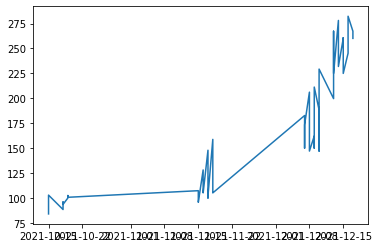

In [189]:
api = "alpha"
goods = a.sort_values("pv",ascending=False).head(10).iloc[0]
current_trades = t[(t["signal"]==goods["signal"].item())
                       & (t["req"]==goods["req"].item())
                    & (t["value"]==goods["value"].item())
                    & (t["conservative"]==goods["conservative"].item())
                        & (t["retrack_day"]==goods["retrack_day"].item())
                   & (t["projection_day"]==goods["projection_day"].item())                          
                  ]
current_trades.sort_values("sell_date",inplace=True)
if current_trades.index.size > 1:
    viz = []
    row = current_trades.iloc[0]
    pv = 100
    start_date = row["date"]
    symbol = row["symbol"]
    amount = float(pv/row["buy_price"])
    end_date = row["sell_date"]
    pv2 = amount * row["sell_price"]
    viz.append({"date":start_date,"crypto":symbol,"amount":amount})
    viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    track_date = start_date
    while track_date < end_date - timedelta(days=1):
        track_date = track_date + timedelta(days=1)
        viz.append({"date":track_date,"crypto":symbol,"amount":amount})
    for i in range(1,current_trades.index.size-1):
        row = current_trades.iloc[i]
        symbol = current_trades.iloc[i]["symbol"]
        start_date = row["date"]
        pv = pv2
        amount =  pv /row["buy_price"]
        viz.append({"date":start_date,"crypto":symbol,"amount":amount})
        track_date = start_date
        end_date = row["sell_date"]
        while track_date < end_date:
            track_date = track_date + timedelta(days=1)
            viz.append({"date":track_date,"crypto":symbol,"amount":amount})
        pv2 = amount * row["sell_price"]
        viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    window = pd.DataFrame(viz)
    example = final.rename(columns={"symbol":"crypto"}).merge(window,how="left",on=["date","crypto"])
    example = example.dropna().sort_values("date")
    example["actual"] = example["amount"] * example["close"]
#     example["bench_delta"] = (example["btc"] - example["btc"].iloc[0]) / example["btc"].iloc[0]
    example["actual_delta"] = (example["actual"] - example["actual"].iloc[0]) / example["actual"].iloc[0]
    plt.plot(example["date"],example["actual"])
#         plt.plot(example["date"],example["bench_delta"])
plt.show()

In [190]:
symbol_analysis = []
for symbol in current_trades["symbol"].unique():
    symbol_trades = current_trades[current_trades["symbol"]==symbol]
    trades = symbol_trades.index.size
    initial = 1
    for delta in symbol_trades["delta"]:
        initial = initial * 1+delta
    symbol_return = initial
    symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
    symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]
    symbol_analysis.append({"symbol":symbol,"return":initial,"trades":trades,"hpr":symbol_trades["days"].mean()})

In [191]:
pd.DataFrame(symbol_analysis).sort_values("return",ascending=False)

,symbol,return,trades,hpr
0,luna,1.5,2,3.5
1,avax,1.5,3,4.0


In [193]:
current_trades[["symbol","date","sell_date","type","delta","buy_price","sell_price"]]

,symbol,date,sell_date,type,delta,buy_price,sell_price
111,luna,2021-10-15,2021-10-19,breakeven,0.0,42.63,42.630
132,luna,2021-11-15,2021-11-18,profit,0.5,40.28,60.420
147,avax,2021-12-07,2021-12-10,profit,0.5,80.61,120.915
151,avax,2021-12-13,2021-12-17,breakeven,0.0,98.21,98.210
158,avax,2021-12-22,2021-12-27,breakeven,0.0,107.06,107.060
